In [ ]:
!pip install pyvis -q

In [243]:
%load_ext autoreload  
%autoreload 2
    
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import networkx as nx
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.PCUtils.BackgroundKnowledge import BackgroundKnowledge
from scipy.stats import pearsonr

from tqdm import tqdm
tqdm.pandas()

pd.set_option('display.max_columns', None)
np.random.seed(42)

In [388]:
data = pd.read_csv('UCI_Credit_Card.csv/UCI_Credit_Card.csv', index_col=0)

### Preprocessing

In [391]:
data = data.rename(columns={'default.payment.next.month': 'def_pay', 
                        'PAY_0': 'PAY_1',
                         'LIMIT_BAL': 'CREDIT_AMOUNT'})

In [393]:
data = data[data['EDUCATION'] > 0]
data = data[data['MARRIAGE'] != 3]
data = data[data['SEX'] > 0]

In [395]:
data['SEX'] = data['SEX'] - 1 
data[data['EDUCATION'] == 6] = 5

In [397]:
data = data.drop('EDUCATION', axis=1).merge(pd.get_dummies(data['EDUCATION'], prefix='EDU').astype('int'), on='ID')

In [399]:
data = data.rename(columns={'EDU_1':'EDU_GRADUATE_SCHOOL', 'EDU_2':'EDU_UNIVERSITY', 'EDU_3':'EDU_HIGH_SCHOOL', 'EDU_4':'EDU_OTHER', 'EDU_5':'EDU_UNKNOWN'})

In [451]:
data = data.drop('EDU_UNKNOWN', axis=1)

In [469]:
data.columns

Index(['CREDIT_AMOUNT', 'SEX', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2', 'PAY_3',
       'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
       'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
       'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'def_pay',
       'EDU_GRADUATE_SCHOOL', 'EDU_UNIVERSITY', 'EDU_HIGH_SCHOOL',
       'EDU_OTHER'],
      dtype='object')

### BG generation

Cоздаем матрицу экспертных знаний (aka background knowledge):

In [454]:
bg_map = {i:node for i,node in enumerate(data.columns)}
bg_map_r = {node:i for i,node in enumerate(data.columns)}

bg = np.zeros((len(data.columns), len(data.columns))) - 1

Для простоты формирования background knowledge объединим переменные в группы:

In [471]:
demographic_fixed_vars = ['SEX', 'AGE']
demographic_other_vars = ['MARRIAGE']
education_vars = [col for col in data.columns if 'EDU' in col]
credit_desc_vars = ['CREDIT_AMOUNT']
target_variables = ['def_pay']

payment_vars_1 = [col for col in data.columns if '1' in col]
payment_vars_2 = [col for col in data.columns if '2' in col]
payment_vars_3 = [col for col in data.columns if '3' in col]
payment_vars_4 = [col for col in data.columns if '4' in col]
payment_vars_5 = [col for col in data.columns if '5' in col]
payment_vars_6 = [col for col in data.columns if '6' in col]

payments_vars = [payment_vars_1, payment_vars_2, payment_vars_3, payment_vars_4, payment_vars_5, payment_vars_6]

Избавляемся от направленных ребер в прошлое из будущего:

In [459]:
for i, payment_var in enumerate(payments_vars):
    for v_from in payment_var:
        for v_to in np.reshape(payments_vars[i+1:], -1):
            bg[bg_map_r[v_from]][bg_map_r[v_to]] = 0

for v_from in target_variables:
    for v_to in np.reshape(payments_vars, -1):
        bg[bg_map_r[v_from]][bg_map_r[v_to]] = 0

for v_from in target_variables:
    for v_to in demographic_fixed_vars + demographic_other_vars:
        bg[bg_map_r[v_from]][bg_map_r[v_to]] = 0

for v_from in np.reshape(payments_vars, -1):
    for v_to in credit_desc_vars:
        bg[bg_map_r[v_from]][bg_map_r[v_to]] = 0

Избавляемся от направленных ребер в демографические переменные:

In [480]:
for v_to in demographic_fixed_vars:
    for v_from in np.reshape(payments_vars, -1):
        bg[bg_map_r[v_from]][bg_map_r[v_to]] = 0
    
    for v_from in credit_desc_vars:
        bg[bg_map_r[v_from]][bg_map_r[v_to]] = 0

    for v_from in education_vars:
        bg[bg_map_r[v_from]][bg_map_r[v_to]] = 0

    for v_from in demographic_other_vars + target_variables:
        bg[bg_map_r[v_from]][bg_map_r[v_to]] = 0

Удаляем связи типа 'переменные баланса -> образование':

In [ ]:
for v_from in np.reshape(payments_vars, -1):
    for v_to in education_vars:
        bg[bg_map_r[v_from]][bg_map_r[v_to]] = 0

for v_from in credit_desc_vars:
    for v_to in education_vars:
        bg[bg_map_r[v_from]][bg_map_r[v_to]] = 0

Скоррелированы, но не связаны (существует конфаундер вне датасета):

In [540]:
 bg[bg_map_r['AGE']][bg_map_r['SEX']] = 0
 bg[bg_map_r['SEX']][bg_map_r['AGE']] = 0

### Causal discovery

In [553]:
alpha = 0.001
ci_test = 'fisherz'

g = pc(data.values, alpha=alpha, ci_test=ci_test)
bk = get_bk(g, bg)
g = pc(data.values, alpha=alpha, ci_test=ci_test, background_knowledge=bk)

g.to_nx_graph()
g = nx.relabel_nodes(g.nx_graph, {prev_node:new_node for prev_node, new_node in zip(g.nx_graph.nodes, data.columns)})

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

0.21367521367521367


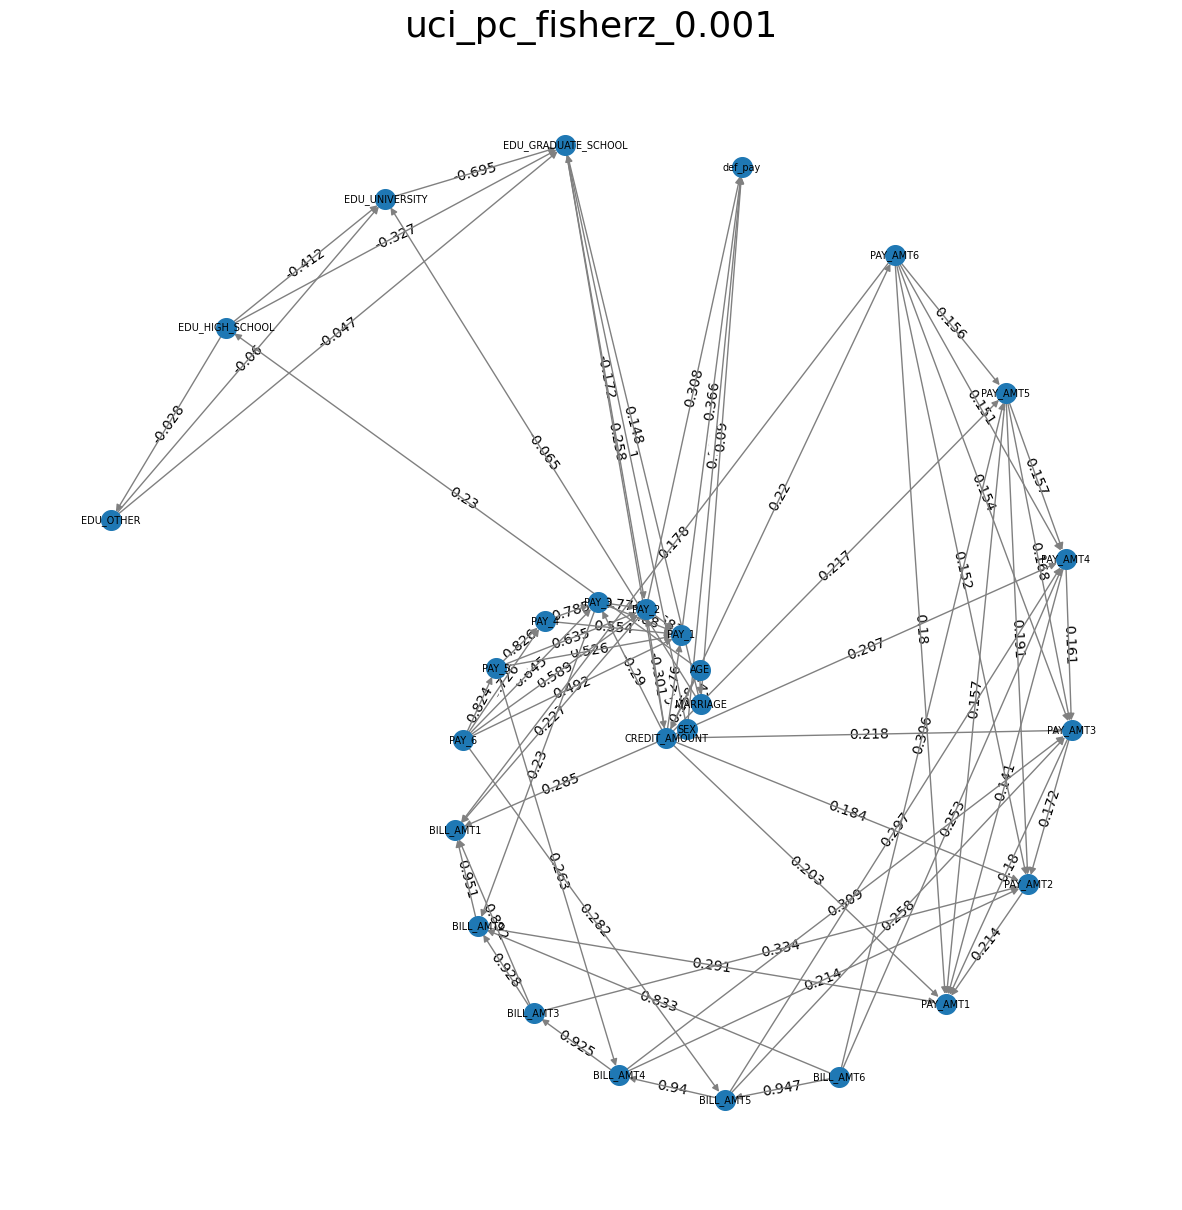

In [569]:
draw(g, f'uci_pc_{ci_test}_{alpha}', nx.spiral_layout)

In [567]:
from pyvis.network import Network
import pyvis


def draw(graph, graph_name, layout):

    def nudge(pos, x_shift, y_shift):
        return {n:(x + x_shift, y + y_shift) for n,(x,y) in pos.items()}
    
    
    print(len(graph.edges)/(len(graph.nodes)*(len(graph.nodes)-1)/2))
    edge_colors = ['red' if (y,x) in graph.edges() else 'grey' for (x,y) in graph.edges()]
    pos = layout(graph) #  resolution=0.15,equidistant=False
    pos_nodes = nudge(pos, 0.0, 0)
    
    e_l = dict()
    for edge in graph.edges():
        corr = np.round(pearsonr(data[edge[0]], data[edge[1]])[0], 3)
        e_l[edge] = str(corr)
    
    node_colors = []

    for node in graph.nodes:
        
        if node in np.reshape(payments_vars, -1):
            node_colors.append('#BF3030')
            graph.nodes[node]['color'] = '#BF3030'
        elif node in ['def_pay']:
            node_colors.append('black')
            graph.nodes[node]['color'] = 'black' 
        elif node in demographic_fixed_vars + demographic_other_vars:
            node_colors.append('#1D7373')
            graph.nodes[node]['color'] = '#1D7373'
        elif node in credit_desc_vars:
            node_colors.append('#B9F73E')
            graph.nodes[node]['color'] = '#B9F73E'            
        else:
            node_colors.append('#c6c5ca')
            graph.nodes[node]['color'] = '#c6c5ca'
    
    fig, ax = plt.subplots(1, figsize=(15, 15))
    
    ax.set_title(f'{graph_name}', loc='center', fontsize=26)
    nx.set_edge_attributes(graph, values = e_l, name = 'label')
    nx.set_edge_attributes(graph, values = e_l, name = 'title')
    nx.draw_networkx_edge_labels(graph, ax=ax, pos=pos, edge_labels=e_l, label_pos=0.5)
    nx.draw_networkx_labels(graph, ax=ax, pos=pos_nodes, font_size=7)

    
    
    nx.draw(graph,
            ax=ax,
            with_labels=False,
            node_size=200,
            edge_color=edge_colors,
            pos=pos,
            font_size=10)
    
    nt = Network(height='780px', width='100%', directed=True)
    if pyvis._version.__version__ > '0.1.9':
        nt.from_nx(graph, show_edge_weights=False)
    else:
        nt.from_nx(graph)
        
 #   nt.show_buttons(filter_=['physics'])
    nt.force_atlas_2based()
#    nt.show('nx.html')
    nt.write_html(graph_name + '.html', notebook=False)

    return graph

In [205]:
def get_bk(pc_graph_after, bg):
    '''
    Create BackgroundKnowledge object based on the actual background knowledge
    and generated previously (without BK) causal graph
    
    :pc_graph_after: output of the PC algortihm 

    '''

    nodes = pc_graph_after.G.get_nodes()
    
    bk = BackgroundKnowledge() 

    for i in range(len(bg)):
        for j in range(len(bg[i])):
            if bg[i][j] == 0:
                bk.add_forbidden_by_node(nodes[i], nodes[j])

    bk.add_forbidden_by_node(nodes[-1], nodes[-2]) # this forbids the e -> t relation
    
    return bk

In [92]:
!pip install pyvis -q